![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">Machine Learning - Tabular Data</a>


## Product Substitute Prediction

__Problem Definition__:
Given a pair of products, (A, B), we say that B is a "substitute" for A if a customer would buy B in place of A -- say, if A were out of stock.

The goal of this project is to predict a substitute relationship between pairs of products.

__Datasets and Files:__


* __training.csv__: Training product pairs:
> - `ID:` ID of the record
> - `label:` Tells whether the key and candidate products are substitutes (1) or not (0).
> - `key_asin ...:` Key product ASIN features 
> - `cand_asin ...:` Candidate product ASIN features 


* __public_test_features.csv__: Test product pairs:
> - `ID:` ID of the record
> - `key_asin ...:` Key product ASIN features 
> - `cand_asin ...:` Candidate product ASIN features 


* __metadata-dataset.xlsx__: Provides detailed information about all key_ and cand_ columns in the training and test sets.

In [1]:
# Upgrade dependencies
! pip install -q pandas==1.1.5
! pip install -q scikit-learn==0.23.2
! pip install -q nltk==3.4.4
! pip install -q matplotlib==3.3.4
! pip install -q numpy==1.19.5
! pip install -q torch==1.8.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


## 1. Read training and test datasets


In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)

import warnings
warnings.filterwarnings("ignore")
  
training_data = pd.read_csv('./data/final_project/training.csv')
test_data = pd.read_csv('./data/final_project/public_test_features.csv')

print('The shape of the training dataset is:', training_data.shape)
print('The shape of the test dataset is:', test_data.shape)

The shape of the training dataset is: (36803, 228)
The shape of the test dataset is: (15774, 227)


## 2. Data Processing

### Exploratory Data Analysis

Examine number of rows, columns, and some simple statistics of the datasets.

In [3]:
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#pd.set_option('display.max_colwidth', None)
training_data.head()

,ID,label,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,...,cand_pkg_weight,cand_pkg_weight_uom,cand_pkg_width,cand_release_date_embargo_level,cand_dw_creation_date,cand_dw_last_updated,cand_is_deleted,cand_last_updated,cand_version,cand_external_testing_certification
0,34016,0,1,1,B00YCZ6IKA,kitchen,Kitchen,NICLW,NaN,base_product,...,0.529104,pounds,5.118110,NaN,18-Apr-13,14-Oct-17,N,13-Oct-17,2867,NaN
1,3581,0,1,1,B00U25WT7A,office_product,Office Product,NaN,NaN,base_product,...,0.100000,pounds,4.500000,NaN,19-May-16,21-Mar-18,N,20-Mar-18,65,NaN
2,36025,1,1,1,B011BZ3GXU,consumer_electronics,Electronics,NaN,NaN,base_product,...,0.654773,pounds,3.937008,NaN,10-Dec-15,16-Feb-18,N,15-Feb-18,1532,NaN
3,42061,1,1,1,B0089XDG3I,pc,Personal Computers,NaN,NaN,base_product,...,3.549442,pounds,10.314961,NaN,19-Oct-12,15-Feb-18,N,14-Feb-18,13964,NaN
4,14628,1,1,1,B014UTSBZW,miscellaneous,Misc.,ZUKC7,1.0,base_product,...,0.396832,pounds,5.196850,NaN,26-Jul-12,9-Mar-18,N,9-Mar-18,1253,NaN


In [4]:
test_data.head()

,ID,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,key_classification_description,...,cand_pkg_weight,cand_pkg_weight_uom,cand_pkg_width,cand_release_date_embargo_level,cand_dw_creation_date,cand_dw_last_updated,cand_is_deleted,cand_last_updated,cand_version,cand_external_testing_certification
0,35057,1,1,B0096M8VR2,pc,Personal Computers,NaN,1.0,base_product,Base Product,...,0.925932,pounds,5.826772,NaN,10-Apr-13,5-Jul-16,N,4-Jul-16,699,NaN
1,41573,1,1,B00EAQJCWW,kitchen,Kitchen,BUNN9,2.0,base_product,Base Product,...,NaN,NaN,NaN,NaN,17-Mar-16,17-Mar-16,N,17-Mar-16,2,NaN
2,44029,1,1,B013P93YOQ,toy,Toy,NaN,NaN,base_product,Base Product,...,NaN,NaN,NaN,NaN,23-Dec-15,2-Dec-17,N,2-Dec-17,17,NaN
3,6462,1,1,B00SKJPKGW,wireless_phone_accessory,Wireless Phone Accessory,PIQ22,1.0,base_product,Base Product,...,6.250000,pounds,9.700000,NaN,22-Jan-15,18-Jan-17,N,18-Jan-17,25351,NaN
4,17533,1,1,B001DCEKXM,sports,Sports,SUUNR,1.0,base_product,Base Product,...,0.176368,pounds,3.228346,NaN,4-Jan-11,16-Nov-17,N,16-Nov-17,7424,NaN


In [5]:
training_data.describe()

,ID,label,key_Region Id,key_MarketPlace Id,key_case_pack_quantity,key_country_of_origin,key_discontinued_date,key_ean,key_excluded_direct_browse_node_id,key_fedas_id,...,cand_recall_notice_receive_date,cand_unit_count,cand_upc,cand_variation_theme_id,cand_video_game_region,cand_pkg_height,cand_pkg_length,cand_pkg_weight,cand_pkg_width,cand_version
count,36803.000000,36803.000000,36803.0,36803.0,16508.000000,0.0,0.0,3.338900e+04,1.013200e+04,33.0,...,0.0,4751.000000,2.710200e+04,14347.000000,14.000000,29405.000000,29405.000000,29135.000000,29405.000000,36803.000000
mean,26341.493438,0.505095,1.0,1.0,9.828326,NaN,NaN,1.704312e+12,1.931567e+09,100954.0,...,NaN,46.670352,6.207103e+11,36.932808,1.428571,3.497030,12.478694,5.806474,7.670509,11493.830014
std,15159.339391,0.499981,0.0,0.0,72.961235,NaN,NaN,2.406607e+12,3.543757e+09,0.0,...,NaN,746.862227,2.750663e+11,91.314273,0.851631,3.773179,11.434224,27.061422,5.980064,75595.969332
min,1.000000,0.000000,1.0,1.0,0.000000,NaN,NaN,1.427901e+07,1.722820e+05,100954.0,...,NaN,0.000000,5.012000e+03,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,13250.500000,0.000000,1.0,1.0,1.000000,NaN,NaN,6.464370e+11,1.064954e+06,100954.0,...,NaN,1.000000,6.134230e+11,2.000000,1.000000,1.100000,6.300000,0.250000,3.818898,53.000000
50%,26318.000000,1.000000,1.0,1.0,1.000000,NaN,NaN,7.571830e+11,1.657930e+08,100954.0,...,NaN,1.000000,7.157180e+11,8.000000,1.000000,2.400000,9.200000,0.750000,5.905512,195.000000
75%,39455.500000,1.000000,1.0,1.0,6.000000,NaN,NaN,8.809600e+11,2.445458e+09,100954.0,...,NaN,12.000000,7.938420e+11,24.000000,1.000000,4.330709,14.100000,2.802126,9.900000,1175.000000
max,52576.000000,1.000000,1.0,1.0,1700.000000,NaN,NaN,9.825480e+12,1.634073e+10,100954.0,...,NaN,50000.000000,9.999980e+11,1437.000000,3.000000,74.000000,202.400000,2322.000000,97.000000,635453.000000


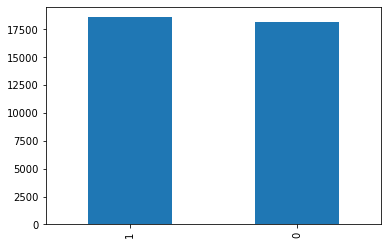

In [6]:
import matplotlib.pyplot as plt
training_data['label'].value_counts().plot.bar()
plt.show()

#### Dataset features

In [7]:
# Implement here
model_features = training_data.columns.drop('label')
for feature in model_features:
    print(feature)

ID
key_Region Id
key_MarketPlace Id
key_ASIN
key_Binding Code
key_binding_description
key_brand_code
key_case_pack_quantity
key_classification_code
key_classification_description
key_color_map
key_country_of_origin
key_cpsia_cautionary_statement
key_creation_date
key_currency_code
key_customer_return_method
key_customer_return_policy
key_delivery_option
key_discontinued_date
key_ean
key_esrb_age_rating
key_esrb_descriptors
key_excluded_direct_browse_node_id
key_fedas_id
key_fma_qualified_price_max
key_fma_override
key_Product Group Code
key_Product Group Description
key_has_ean
key_has_online_play
key_has_platform
key_has_recommended_browse_nodes
key_has_upc
key_inner_package_type
key_is_adult_product
key_is_advantage
key_is_certified_organic
key_is_conveyable
key_is_discontinued
key_is_manufacture_on_demand
key_is_phone_upgradeable
key_Is Sortable
key_is_super_saver_shipping_excl
key_isbn
key_item_classification_id
key_item_display_diameter
key_item_display_height
key_item_display_len

In [8]:
# Scan for outliers in key numerical features
numerical_features = ["key_item_package_quantity", 
                      "key_item_height", "key_item_width", "key_item_length", "key_item_weight", 
                      "key_pkg_height", "key_pkg_width", "key_pkg_length", "key_pkg_weight",
                      "cand_item_package_quantity", 
                      "cand_item_height", "cand_item_width", "cand_item_length", "cand_item_weight", 
                      "cand_pkg_height", "cand_pkg_width", "cand_pkg_length", "cand_pkg_weight"]
for i in range(0,len(numerical_features)):
    print(training_data[numerical_features[i]].value_counts(bins=10, sort=False))

(0.5, 50.9]       33593
(50.9, 100.8]       140
(100.8, 150.7]        0
(150.7, 200.6]        0
(200.6, 250.5]        0
(250.5, 300.4]        0
(300.4, 350.3]        0
(350.3, 400.2]        0
(400.2, 450.1]        0
(450.1, 500.0]       26
Name: key_item_package_quantity, dtype: int64
(-0.109, 10.8]    21679
(10.8, 21.6]       3276
(21.6, 32.4]        773
(32.4, 43.2]        409
(43.2, 54.0]        107
(54.0, 64.8]         47
(64.8, 75.6]         57
(75.6, 86.4]         29
(86.4, 97.2]          0
(97.2, 108.0]        76
Name: key_item_height, dtype: int64
(-0.217, 21.6]    24713
(21.6, 43.2]        832
(43.2, 64.8]        434
(64.8, 86.4]        165
(86.4, 108.0]       142
(108.0, 129.6]      137
(129.6, 151.2]        0
(151.2, 172.8]        0
(172.8, 194.4]        0
(194.4, 216.0]       30
Name: key_item_width, dtype: int64
(-0.361, 36.0]    24614
(36.0, 72.0]       1254
(72.0, 108.0]       352
(108.0, 144.0]      147
(144.0, 180.0]       32
(180.0, 216.0]       30
(216.0, 252.0]     

In [9]:
# Remove outliers
dropIndexes = training_data[training_data[numerical_features[10]] > 3300].index
training_data.drop(dropIndexes , inplace=True)
dropIndexes = training_data[training_data[numerical_features[11]] > 42500].index
training_data.drop(dropIndexes , inplace=True)
dropIndexes = training_data[training_data[numerical_features[12]] > 37000].index
training_data.drop(dropIndexes , inplace=True)

In [10]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(training_data, test_size=0.15, shuffle=True, random_state=23)

# Train - Val Split
print('Train - Validation Datasets shapes: ', train_data.shape, val_data.shape)

Train - Validation Datasets shapes:  (31279, 228) (5520, 228)


### Select features to build the model

Reduce features by considering it as a similarity search (calculate differences between key and candidate features)

In [11]:
numerical_features = ["item_package_quantity", "fma_qualified_price_max",
                      "item_height", "item_width", "item_length", "item_weight",
                      "pkg_height", "pkg_width", "pkg_length", "pkg_weight"]

categorical_features = ["classification_code", "product_type", "Product Group Description", "has_ean", "has_online_play"]

text_features = ["item_name"]

model_features = numerical_features + categorical_features + text_features

model_target = "label"

In [12]:
# Return mean difference between numerical columns, used for imputation purposes
def get_means(df):
    d = {}
    for c in numerical_features:
        d[c] = abs(df['key_' + c].mean() - df['cand_' + c].mean())
    return d

In [13]:
# Helper functions for text processing
import re, string
import nltk
from nltk.stem import SnowballStemmer

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
def get_cv(df):
    cv = CountVectorizer()
    corpus = df['key_item_name'] + df['cand_item_name']
    cleaned_feature = [cleanSentence(str(item), stop_words, stemmer) for item in corpus]
    cv.fit(cleaned_feature)
    #print('Vocabulary: \n', cv.vocabulary_)
    return cv

In [15]:
from scipy.sparse import csr_matrix, find
# Takes in dataframe that was pulled from .csv
# Returns dataframe with augmented features added
def augment_features(df, means, cv):
    df = df.reset_index(drop=True)
    for c in numerical_features:
        df[c] = abs(df['key_' + c] - df['cand_' + c])
        df[c].fillna(means[c], inplace=True)
    for c in categorical_features:
        df[c] = np.where(df['key_' + c] == df['cand_' + c], 1, 0)
    for c in text_features:
        df['key_' + c].fillna("", inplace=True)
        df['cand_' + c].fillna("", inplace=True)
        df[c] = 0
        key = cv.transform(df['key_' + c])
        cand = cv.transform(df['cand_' + c])
        key_I, key_J, key_V = find(key)
        cand_I, cand_J, cand_V = find(cand)
        key_dict = {}
        for x in range(len(key_I)):
            loc = (key_I[x], key_J[x])
            val = key_V[x]
            key_dict[loc] = val
            
        for x in range(len(cand_I)):
            loc = (cand_I[x], cand_J[x])
            val = cand_V[x]
            if loc in key_dict.keys():
                df.at[loc[0], c] = df.at[loc[0], c] + key_dict[loc] + val
    return df

In [16]:
means = get_means(train_data)
cv = get_cv(train_data)

In [17]:
augment_features(train_data, means, cv)[['label'] + model_features]

,label,item_package_quantity,fma_qualified_price_max,item_height,item_width,item_length,item_weight,pkg_height,pkg_width,pkg_length,pkg_weight,classification_code,product_type,Product Group Description,has_ean,has_online_play,item_name
0,1,0.000000,39.380000,0.000000,0.000000,0.000000,1.250544,0.300000,0.200000,0.700000,0.400000,1,0,0,1,1,4
1,1,1.195188,34.060000,0.195687,0.929239,0.019362,1.250544,0.400000,0.600000,2.900000,0.260000,1,0,0,0,1,22
2,0,1.195188,19.158222,0.195687,0.929239,0.019362,1.250544,0.234959,0.366078,0.353604,0.425203,1,1,1,1,1,6
3,0,0.000000,24.410000,4.000000,2.500000,1.500000,0.000000,0.800000,0.700000,2.200000,0.000000,1,1,1,1,1,4
4,0,0.000000,218.000000,40.300000,7.500000,12.200000,22.000000,8.500000,5.400000,33.100000,22.450963,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31274,1,2.000000,20.510000,0.195687,0.929239,0.019362,1.250544,0.207087,3.913386,2.980315,0.549379,1,1,1,1,1,8
31275,1,0.000000,3.830000,0.195687,0.929239,0.019362,1.250544,0.200000,0.200000,0.600000,0.000000,1,1,1,1,1,23
31276,1,0.000000,43.900000,1.500000,1.750000,1.350000,1.250544,1.968504,2.992126,1.417323,0.727525,1,0,0,1,1,0
31277,1,0.000000,302.990000,0.195687,0.929239,0.019362,1.250544,0.234959,0.366078,0.353604,0.425203,1,0,0,1,1,8


In [18]:
X_train = augment_features(train_data, means, cv)[model_features].to_numpy()
y_train = train_data[model_target].to_numpy()

X_val = augment_features(val_data, means, cv)[model_features].to_numpy()
y_val = val_data[model_target].to_numpy()

print('Datasets shapes after processing: ', X_train.shape, X_val.shape)
print('Label shapes: ', y_train.shape, y_val.shape)

Datasets shapes after processing:  (31279, 16) (5520, 16)
Label shapes:  (31279,) (5520,)


In [19]:
import torch
from torch import nn

# Hyper-paramaters of the system
batch_size = 16
num_epochs = 15
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)

train_dataset = torch.utils.data.TensorDataset(X_train,
                                               y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

net = nn.Sequential(
    nn.Linear(in_features=16, out_features=128),
    nn.ReLU(),
    nn.Dropout(p=.2),
    nn.Linear(128, 128), 
    nn.ReLU(),
    nn.Dropout(p=.2),
    nn.Linear(128, 128), 
    nn.Sigmoid(),
    nn.Dropout(p=.2),
    nn.Linear(128, 2)
)               

def xavier_init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(xavier_init_weights)

# Binary Cross Entropy loss for classification
loss = nn.CrossEntropyLoss()

# Stochastic Gradient Descent optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [20]:
import time
for epoch in range(num_epochs):
    start = time.time()
    training_loss = 0.0
    
    net.train() # Activate training mode
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)

        output = net(data)
        L = loss(output, target)
        L.backward()
        optimizer.step()

        training_loss += L.item()
    
    net.eval() # Activate eval mode
    val_predictions = net(X_val)
    val_loss = loss(val_predictions, y_val).item()
    
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)
    
    end = time.time()
    print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
          (epoch, training_loss, val_loss, end-start))

Epoch 0. Train_loss 0.044658 Validation_loss 0.000118 Seconds 1.937157
Epoch 1. Train_loss 0.042833 Validation_loss 0.000117 Seconds 1.942261
Epoch 2. Train_loss 0.042218 Validation_loss 0.000117 Seconds 1.945607
Epoch 3. Train_loss 0.041972 Validation_loss 0.000117 Seconds 1.968773
Epoch 4. Train_loss 0.041777 Validation_loss 0.000117 Seconds 1.975882
Epoch 5. Train_loss 0.041520 Validation_loss 0.000116 Seconds 1.967769
Epoch 6. Train_loss 0.041510 Validation_loss 0.000116 Seconds 1.974058
Epoch 7. Train_loss 0.041276 Validation_loss 0.000116 Seconds 1.946802
Epoch 8. Train_loss 0.041204 Validation_loss 0.000116 Seconds 1.958326
Epoch 9. Train_loss 0.040999 Validation_loss 0.000116 Seconds 1.966944
Epoch 10. Train_loss 0.041013 Validation_loss 0.000116 Seconds 1.962499
Epoch 11. Train_loss 0.040900 Validation_loss 0.000116 Seconds 1.956675
Epoch 12. Train_loss 0.040797 Validation_loss 0.000116 Seconds 1.945217
Epoch 13. Train_loss 0.040759 Validation_loss 0.000116 Seconds 1.945095
Ep

In [21]:
from sklearn.metrics import classification_report

net.eval() # Activate eval mode

predictions = net(X_val)
print(predictions)
print(y_val)

# Printing performance on the val data
print(classification_report(y_val, predictions.argmax(axis=1).detach().numpy()))

tensor([[-0.3666, -0.1528],
        [-0.0065,  0.3061],
        [-0.9824,  0.3899],
        ...,
        [-0.7203, -0.2249],
        [-0.2293, -0.0668],
        [-0.7168,  0.2041]], grad_fn=<AddmmBackward>)
tensor([1, 0, 1,  ..., 0, 0, 0])
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      2717
           1       0.64      0.66      0.65      2803

    accuracy                           0.64      5520
   macro avg       0.64      0.64      0.64      5520
weighted avg       0.64      0.64      0.64      5520



In [22]:
X_test = augment_features(test_data, means, cv)[model_features].to_numpy()
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
predictions = net(X_test)

In [23]:
test_predictions = []
for t in predictions:
    if t[0] > t[1]:
        test_predictions.append(0)
    else:
        test_predictions.append(1)

In [24]:
result_df = pd.DataFrame(columns=["ID", "label"])
result_df["ID"] = test_data["ID"].tolist()
result_df["label"] = test_predictions

result_df.to_csv("./data/result.csv", index=False)